In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
import os


In [2]:
%pwd

'd:\\mjourFinalPorject\\research'

In [3]:
os.chdir("D://mjourFinalPorject//artifacts//data_ingestion//dcdata")

In [4]:
%pwd

'D:\\mjourFinalPorject\\artifacts\\data_ingestion\\dcdata'

In [5]:
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//train')), "train_dir")
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//test')), "test_dir")
os.listdir("D:/mjourFinalPorject/artifacts/data_ingestion/dcdata")


4801 train_dir
2400 test_dir


['test', 'train']

In [6]:
train_dir = 'D://mjourFinalPorject//artifacts//data_ingestion//dcdata//train'
test_dir = 'D://mjourFinalPorject//artifacts//data_ingestion//dcdata//test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

IMG_SIZE = (128, 128)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)

data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

In [9]:
cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files[:int(len(cat_files)*0.9)], train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files[:int(len(cat_files)*0.9)], train_dir, transform = data_transform)

cat_val = CatDogDataset(cat_files[(int(len(cat_files)*0.9) + 1):], train_dir, transform = data_transform)
dog_val = CatDogDataset(dog_files[(int(len(cat_files)*0.9) + 1):], train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])
dataloader = DataLoader(catdogs, batch_size = 1, num_workers=0)

val_catdogs = ConcatDataset([cat_val, dog_val])
val_dataloader = DataLoader(val_catdogs, batch_size = 32, shuffle=True, num_workers=2)

In [10]:
print("Number of cat files: ",len(cat_files))
print("Number of dog files: ",len(dog_files))

Number of cat files:  2400
Number of dog files:  2400


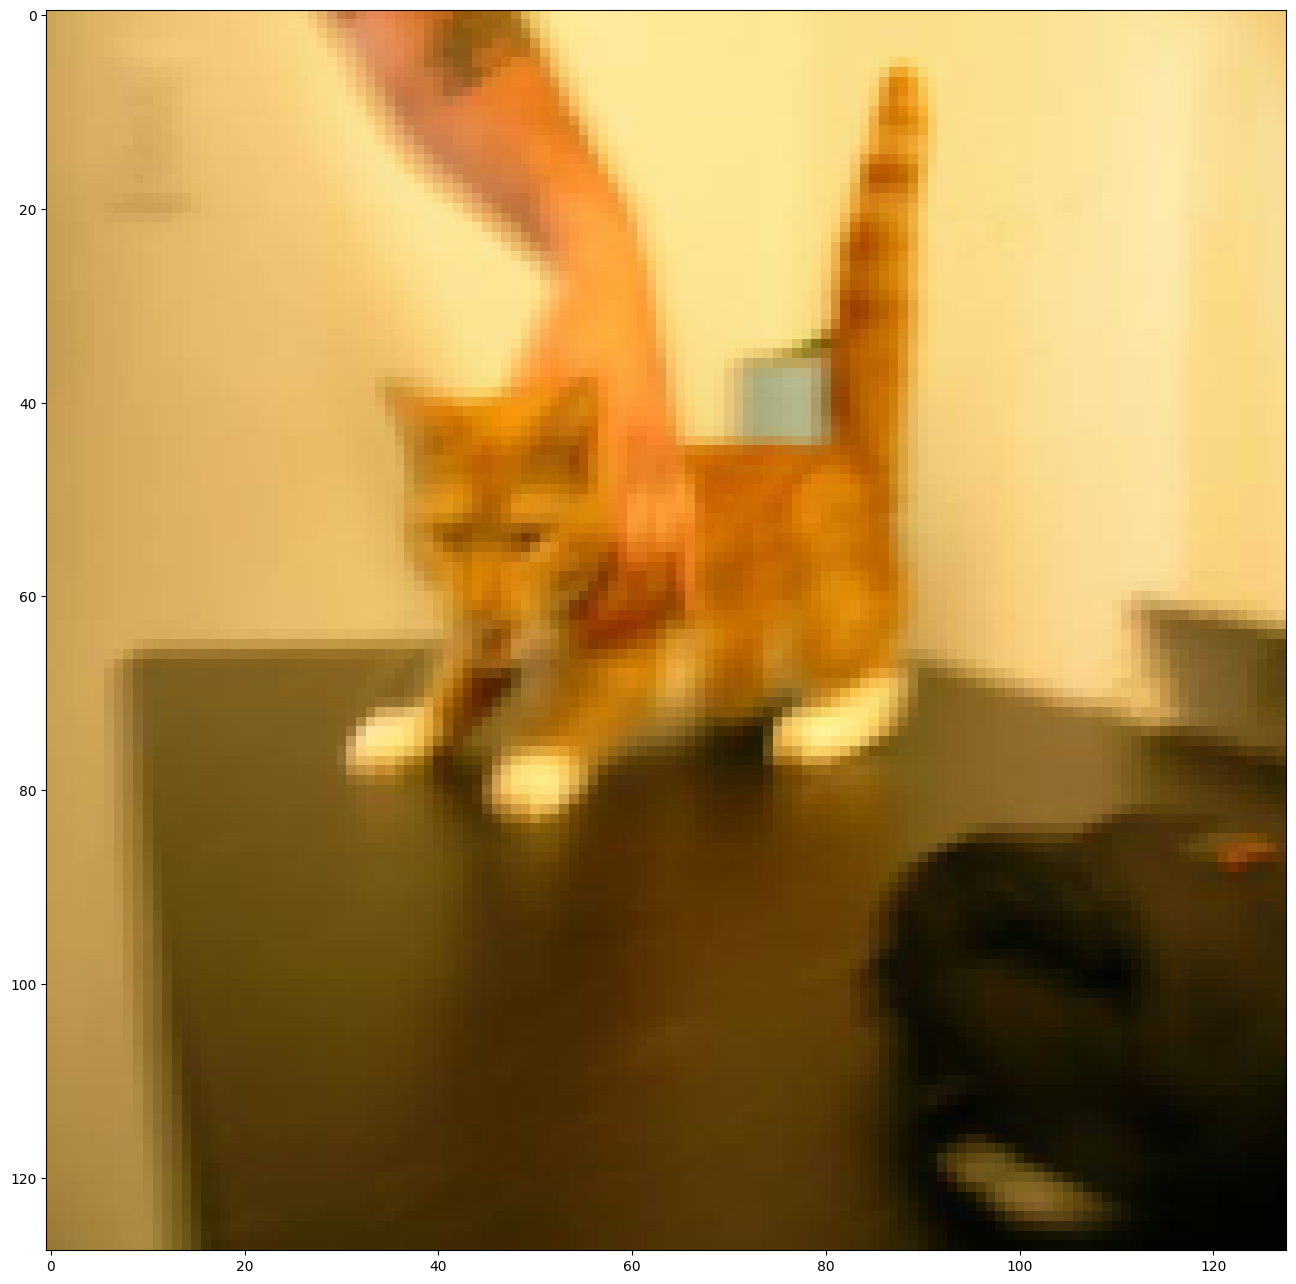

In [11]:
#Test if dataloader worked
df = iter(dataloader)
samples, labels = next(df)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [12]:
pip install vit-pytorch

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\mjourfinalporject\mf\scripts\python.exe -m pip install --upgrade pip' command.


In [13]:
from vit_pytorch import ViT

In [14]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\mjourfinalporject\mf\scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
class ViTModel(nn.Module):
    
    def __init__(self):
        super(ViTModel,self).__init__()
        self.vit = ViT(
                    image_size = IMG_SIZE,
                    patch_size = 16,
                    num_classes = 2,
                    dim = 1024,
                    depth = 6,
                    heads = 16,
                    mlp_dim = 512,
                    dropout = 0.1,
                    emb_dropout = 0.1
                )
    
    def forward(self,x):
        
        x = self.vit(x)
        x = F.softmax(x,dim=-1)
        return x

In [16]:
from torchsummary import summary
#Shape of each input is (32, 3, 128, 128) -> batch size 32
device = 'cuda'
model = ViTModel()
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)

In [18]:
epochs = 50
device = 'cuda'



model.train()
for epoch in range(epochs):
    

    for samples, labels in tqdm(dataloader):
        samples, labels = samples.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output,labels)
        
        loss.backward()
        optimizer.step()
        
        
       
    #Finding accuracy at the end of an epoch
    total_loss = 0
    pred_list = torch.tensor([]).to(device)
    true_list = torch.tensor([]).to(device)
    for samples, labels in val_dataloader:
        samples, labels = samples.to(device), labels.to(device)
        
        output = model(samples)
        total_loss += criterion(output,labels).item()
        pred = torch.argmax(output, dim=1)
        pred_list = torch.cat((pred_list,pred),0)
        true_list = torch.cat((true_list,labels),0)
    
    correct = pred_list.eq(true_list)
    acc = torch.mean(correct.float())
    print('[Epoch {}/{}] -> Train Loss: {:.4f}, val_accuracy: {:.3f}'.format(epoch+1, epochs, total_loss, acc))
        

100%|██████████| 4320/4320 [05:40<00:00, 12.70it/s]


RuntimeError: DataLoader worker (pid(s) 17816, 6816) exited unexpectedly